In [14]:
import pandas as pd
from common import collect_results, normalize_region_name, compute_quantiles
from pathlib import Path
from matplotlib import pyplot as plt

In [22]:
ROOT = Path("tpcc")

def get_matcher(system):
    def matcher(p: Path):   
        import re
        pattern = re.compile(r"tpcc-\d+-%s-terminals\d+-([\d-]+)" % system)
        match = pattern.match(p.name)
        if not match:
            return None

        print("Found result:", p.name)
        return {
            "suffix": str(match.group(1)),
        }
    
    return matcher

In [23]:
import json

def yb_matcher(p: Path):   
    import re
    pattern = re.compile(r"tpcc-(\d+)-yugabyte-terminals(\d+)")
    match = pattern.match(p.name)
    if not match:
        return None

    print("Found result:", p.name)
    return {
        "scalefactor": int(match.group(1)),
        "terminals": int(match.group(2)),
    }

def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

def collect_yugabyte_results(path, renew_cache: bool):
    cache = path / "cache.csv"

    if renew_cache:
        cache.unlink(missing_ok=True)

    if cache.is_file():
        return pd.read_csv(cache)

    records = []
    for result_dir in path.iterdir():
        if not result_dir.is_dir():
            continue

        metadata = yb_matcher(result_dir)
        if metadata is None:
            continue

        for region_path in result_dir.iterdir():
            if not region_path.is_dir():
                continue
            record = {"path": region_path.as_posix(), "region": region_path.name, **metadata}

            raw_df = pd.read_csv(region_path / "oltpbench.csv", skiprows=2)
            raw_df["OperationLatency (microseconds)"] /= 1000

            transactions = raw_df["Transaction Name"].unique()
            for transaction in transactions:
                record.update(
                    compute_quantiles(
                        raw_df[raw_df["Transaction Name"] == transaction]["OperationLatency (microseconds)"],
                        remove_upper_outliers=True,
                        suffix=f".{transaction}"
                    )
                )

            record.update(
                compute_quantiles(
                    raw_df["OperationLatency (microseconds)"],
                    remove_upper_outliers=True
                )
            )

            output = json.loads((region_path / "json" / "output.json").read_text())

            runtime = output["TestConfiguration"]["runTimeInSecs"]
            record["time"] = runtime
            record["warmup"] = output["TestConfiguration"]["warmupTimeInSecs"]
            record["throughput"] = output["Results"]["throughput"]
            for lat in output["Latencies"]:
                if lat["Transaction"] != "All":
                    record[f"throughput.{lat['Transaction']}"] = lat["Count"] / runtime

            records.append(record)
    
    df = pd.DataFrame.from_records(records)
    df.to_csv(cache, index=False)

    return df

# Throughput


In [24]:
SYSTEMS = ["sunstorm", "aurora", "yugabyte"]
RENEW_CACHE = False

sunstorm_matcher = get_matcher("sunstorm")
sunstorm_throughput_df = collect_results(
    ROOT / "sunstorm",
    sunstorm_matcher,
    RENEW_CACHE,
)
normalize_region_name(sunstorm_throughput_df)

aurora_matcher = get_matcher("aurora")
aurora_throughput_df = collect_results(
    ROOT / "aurora",
    aurora_matcher,
    RENEW_CACHE,
)
normalize_region_name(aurora_throughput_df)

yugabyte_matcher = get_matcher("yugabyte")
yugabyte_throughput_df = collect_yugabyte_results(ROOT / "yugabyte", RENEW_CACHE)
normalize_region_name(yugabyte_throughput_df)

In [25]:
throughput_df = pd.concat([
    sunstorm_throughput_df.assign(system="sunstorm", terminals_rank=sunstorm_throughput_df["terminals"].rank(method="dense")),
    aurora_throughput_df.assign(system="aurora", terminals_rank=aurora_throughput_df["terminals"].rank(method="dense")),
    yugabyte_throughput_df.assign(system="yugabyte", terminals_rank=yugabyte_throughput_df["terminals"].rank(method="dense")),
])
throughput_df

,path,region,suffix,rejected,rejected.NewOrder,rejected.Payment,aborted,aborted.NewOrder,unexpected,completed,...,deadlock.Delivery,rejected.StockLevel,unexpected.NewOrder,ood_index_page.StockLevel,ood_table.StockLevel,ood_tuple.StockLevel,other_aborts.StockLevel,deadlock.StockLevel,system,terminals_rank
0,tpcc/sunstorm/tpcc-100-sunstorm-terminals20-20...,1-us-east-1-0,20240517-143519,17.0,8.0,9.0,261.0,261.0,0.0,61379.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sunstorm,3.0
1,tpcc/sunstorm/tpcc-100-sunstorm-terminals20-20...,3-ap-northeast-1-0,20240517-143519,134.0,83.0,51.0,207.0,207.0,0.0,44793.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sunstorm,3.0
2,tpcc/sunstorm/tpcc-100-sunstorm-terminals20-20...,2-eu-west-1-0,20240517-143519,42.0,31.0,11.0,256.0,256.0,0.0,53040.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sunstorm,3.0
3,tpcc/sunstorm/tpcc-100-sunstorm-terminals60-20...,1-us-east-1-0,20240517-143519,1866.0,1097.0,769.0,575.0,575.0,0.0,135951.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sunstorm,5.0
4,tpcc/sunstorm/tpcc-100-sunstorm-terminals60-20...,3-ap-northeast-1-0,20240517-143519,3700.0,2082.0,1617.0,528.0,528.0,0.0,111090.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sunstorm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,tpcc/yugabyte/tpcc-100-yugabyte-terminals128/2...,2-eu-west-1-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yugabyte,5.0
38,tpcc/yugabyte/tpcc-100-yugabyte-terminals128/3...,3-ap-northeast-1-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yugabyte,5.0
39,tpcc/yugabyte/tpcc-100-yugabyte-terminals32/1-...,1-us-east-1-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yugabyte,3.0
40,tpcc/yugabyte/tpcc-100-yugabyte-terminals32/2-...,2-eu-west-1-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yugabyte,3.0


## Scalefactor


In [26]:
throughput_df.pivot_table(
    index=["terminals_rank"], columns=["system", "scalefactor"], values="throughput", aggfunc="sum"
)

system               aurora                  sunstorm              yugabyte  \
scalefactor             10           100          10           100      10    
terminals_rank                                                                
1.0              139.448593   130.932060   140.532313   144.681540    34.44   
2.0              960.777134  1023.472787  1335.872864  1408.820131   420.56   
3.0             1264.437595  1445.483671  1842.687935  2653.513394   456.71   
4.0             1255.054702  1652.509837  2507.356717  4804.184076   544.58   
5.0             1150.475827  1694.321240  2926.209803  6195.821421   545.52   
6.0             1070.822328  1593.899501  3207.204547  7397.430602   509.60   
7.0             1008.838633  1435.549001  3476.415409  7924.252172   508.52   

system                   
scalefactor         100  
terminals_rank           
1.0               28.55  
2.0              460.80  
3.0              900.60  
4.0             1602.29  
5.0             2540.50  
6.0             2293.55  
7.0             2059.01

## Throughput vs. Latency

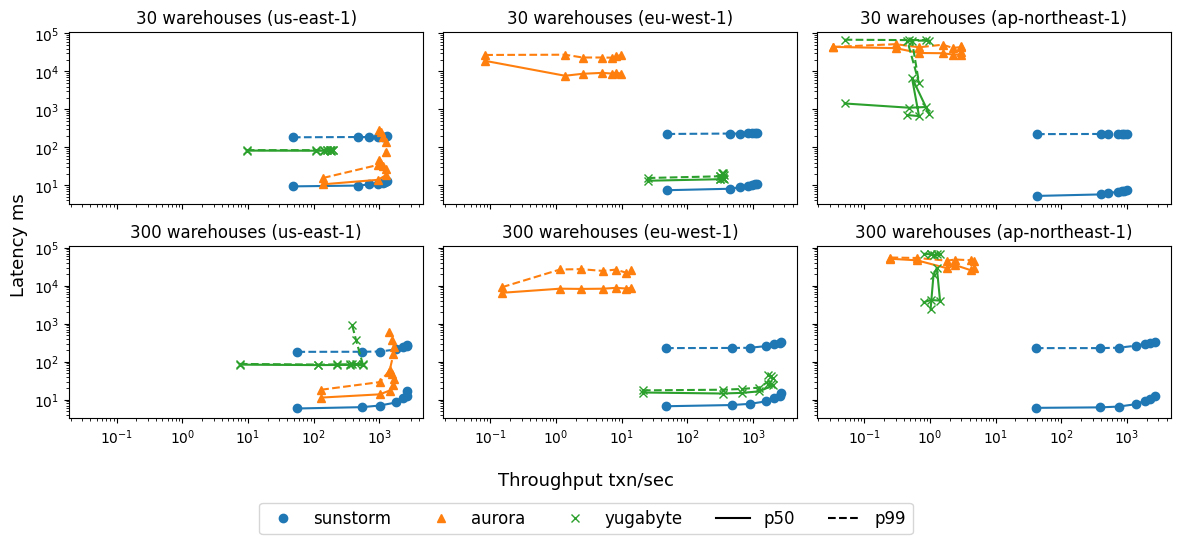

In [27]:
from matplotlib.lines import Line2D

FONT_SIZE_AXES = 13
FONT_SIZE_LEGEND = 12

fig, axes = plt.subplots(2, 3, figsize=(12, 5), sharex=True, sharey=True)

# for scalefactor in [1, 10, 100]:
for s, scalefactor in enumerate([10, 100]):
    scale_df = throughput_df[throughput_df["scalefactor"] == scalefactor]

    for r, region in enumerate(["1-us-east-1-0", "2-eu-west-1-0", "3-ap-northeast-1-0"]):
        region_df = scale_df[scale_df["region"] == region]
        region_name = {
            "1-us-east-1-0": "us-east-1",
            "2-eu-west-1-0": "eu-west-1",
            "3-ap-northeast-1-0": "ap-northeast-1",
        }[region]

        ax = axes[s, r]

        for i, (system, marker) in enumerate(zip(SYSTEMS, ["o", "^", "x"])):
            system_df = region_df[region_df["system"] == system].sort_values("terminals_rank")

            for y, linestyle in [("p50.NewOrder", "-"), ("p99.NewOrder", "--")]:         
                system_df.plot(
                    title=f"{scalefactor*3} warehouses ({region_name})",
                    x="throughput",
                    y=y,                   
                    style=f"{marker}{linestyle}C{i}",
                    rot=0,
                    logy=True,
                    logx=True,
                    # xlim=(-100, 2500),
                    # ylim=(0.2, 30000),
                    legend=False,
                    xlabel="",
                    ylabel="",
                    ax=ax,
                )

fig.supylabel("Latency ms", fontsize=FONT_SIZE_AXES)
fig.supxlabel("Throughput txn/sec", fontsize=FONT_SIZE_AXES)
# fig.suptitle("TPC-C NewOrder Transaction")
       
fig.legend(handles=[
        Line2D([0], [0], lw=0, marker='o', color='C0', markerfacecolor='C0', label='sunstorm'),
        Line2D([0], [0], lw=0, marker='^', color='C1', markerfacecolor='C1', label='aurora'),
        Line2D([0], [0], lw=0, marker='x', color='C2', markerfacecolor='C2', label='yugabyte'),
        Line2D([0], [0], color='k', linestyle='-', label='p50'),
        Line2D([0], [0], color='k', linestyle='--', label='p99'),
    ], 
    title="",
    ncol=5,
    loc="upper center",
    bbox_to_anchor=(0.5,0),
    fontsize=FONT_SIZE_LEGEND
)
fig.tight_layout()
fig.savefig(f"output/tpcc.pdf", bbox_inches="tight")